# Modeling with NN 

In [27]:
## Import need packages 
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization,Dropout

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [5]:
def print_scores(model):
    print(f'train score: {model.score(X_train, y_train)}')
    print(f'test score: {model.score(X_test, y_test)}')

In [6]:
def create_model(units=60, dropout=0, reg=None):
    model = Sequential()
    model.add(Dense(12, input_shape=(1000,), activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(units, activation='relu', kernel_regularizer = reg))
    model.add(Dropout(dropout))
 
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [7]:
# df_reviews = pd.read_csv('../data/Las_Vegas_400_reviews.csv')
# df_reviews = pd.read_csv('../data/Las_Vegas_all_1000_reviews.csv')
df_reviews = pd.read_csv('../data/Las_Vegas_all_reviews.csv')
df_revs_combined = df_reviews.groupby(['business_id', 'name', 
                               'address', 'city' ,
                               'state', 'postal_code', 
                               'latitude' ,'longitude' , 
                               'stars', 'review_count', 
                               'is_open', 'attributes', 'categories']).agg({'text': ' '.join})
df_revs_combined = df_revs_combined.reset_index()
df_revs_combined['review_wc'] = df_revs_combined['text'].str.split().str.len()

X = df_revs_combined['text']
y = df_revs_combined['is_open']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=251)

In [8]:
tf_vect = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_trans = tf_vect.fit_transform(X_train)
X_test_trans = tf_vect.transform(X_test)
X_train_trans = X_train_trans.toarray()
X_test_trans = X_test_trans.toarray()

In [9]:
X_train_trans.shape, X_test_trans.shape

((1326, 1000), (442, 1000))

In [10]:
sscaler = StandardScaler(with_mean=False)
model = KerasClassifier(build_fn=create_model, epochs=10, verbose=0)
pipe = make_pipeline(sscaler,model)

In [11]:
pipe.fit(X_train_trans, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f794224ab50>)])

In [12]:
# params = {'kerasclassifier__units': [10, 20, 100]}
params = {'kerasclassifier__units': [64, 128, 256, 512],
          'kerasclassifier__dropout':[0.2, 0.3, 0.4, 0.5],
          'kerasclassifier__reg':['l2', None],
         }
grid = GridSearchCV(pipe, param_grid=params)

In [13]:
grid.fit(X_train_trans, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('kerasclassifier',
                                        <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f794224ab50>)]),
             param_grid={'kerasclassifier__dropout': [0.2, 0.3, 0.4, 0.5],
                         'kerasclassifier__reg': ['l2', None],
                         'kerasclassifier__units': [64, 128, 256, 512]})

In [14]:
grid.score(X_train_trans, y_train)

0.9819004535675049

In [15]:
grid.score(X_test_trans, y_test)

0.8280543088912964

In [16]:
grid.best_params_

{'kerasclassifier__dropout': 0.5,
 'kerasclassifier__reg': 'l2',
 'kerasclassifier__units': 128}

In [17]:
df_revs_combined['is_open'].value_counts(normalize=True)

1    0.724548
0    0.275452
Name: is_open, dtype: float64

In [18]:
# predics = np.argmax(grid.predict(X_test_trans), axis=1)
predics =  grid.predict(X_test_trans)

/home/babu/code/jupyterenvironment/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [19]:
#predics

In [20]:
tn, fp, fn,tp = confusion_matrix(y_test, predics).ravel()

In [21]:
print(tn, fp, fn,tp)

78 45 31 288


In [22]:
#plot_roc_curve(pipe, X_test_encoded, y_test);

In [23]:
precision = tp / (tp+fp)
recall = tp / (tp+fn)
specificity = tn/(tn+fp)
balanced_accuracy = (specificity + recall)/2
ac = accuracy_score(y_test, predics)
fpr = fp / (fp+tn) # False Positive Rate 
print(f" Precision: {precision}")
print(f" Recall: {recall}")
print(f" Specificity: {recall}")
print(f" Balanced Accuracy: {balanced_accuracy}")
print(f" Accuracy Score: {ac}")
print(f" False Positive Rate : {fpr}")

 Precision: 0.8648648648648649
 Recall: 0.9028213166144201
 Specificity: 0.9028213166144201
 Balanced Accuracy: 0.7684838290389173
 Accuracy Score: 0.8280542986425339
 False Positive Rate : 0.36585365853658536


# Running NN with best Params

## dropout =  0.5
## reg = 'l2'
## units =  128

In [30]:
sscaler = StandardScaler(with_mean=False)
X_train_scaled = sscaler.fit_transform(X_train_trans)
X_test_scaled = sscaler.transform(X_test_trans)

In [34]:
model = Sequential()
model.add(Dense(12, input_shape=(1000,), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu', kernel_regularizer = 'l2'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
history = model.fit(X_train_trans, y_train, validation_data=(X_test_trans, y_test), epochs = 10)

Epoch 1/10
42/42 [==============================] - 1s 4ms/step - loss: 0.8505 - accuracy: 0.6362 - val_loss: 0.7967 - val_accuracy: 0.7217
Epoch 2/10
42/42 [==============================] - 0s 2ms/step - loss: 0.7052 - accuracy: 0.7254 - val_loss: 0.7336 - val_accuracy: 0.7217
Epoch 3/10
42/42 [==============================] - 0s 2ms/step - loss: 0.6033 - accuracy: 0.7805 - val_loss: 0.6841 - val_accuracy: 0.7217
Epoch 4/10
42/42 [==============================] - 0s 2ms/step - loss: 0.5242 - accuracy: 0.8056 - val_loss: 0.6326 - val_accuracy: 0.7217
Epoch 5/10
42/42 [==============================] - 0s 2ms/step - loss: 0.4479 - accuracy: 0.8641 - val_loss: 0.6030 - val_accuracy: 0.7217
Epoch 6/10
42/42 [==============================] - 0s 2ms/step - loss: 0.4068 - accuracy: 0.8624 - val_loss: 0.5661 - val_accuracy: 0.7262
Epoch 7/10
42/42 [==============================] - 0s 2ms/step - loss: 0.3307 - accuracy: 0.8971 - val_loss: 0.5471 - val_accuracy: 0.7489
Epoch 8/10
42/42 [==

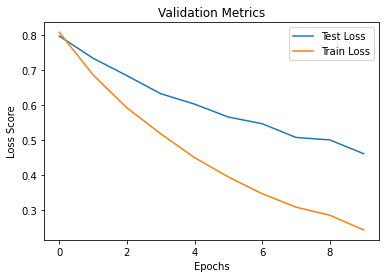

In [36]:
plt.plot(history.history['val_loss'], label='Test Loss')
plt.plot(history.history['loss'], label="Train Loss")
plt.legend()
plt.title('Validation Metrics')
plt.xlabel("Epochs")
plt.ylabel("Loss Score");